# Import the required libraries:

In [1]:
# IMPORT THE libraries
import os
# import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow import keras
from keras import backend as K 
import random
random.seed(42)

# Set up the data using Image Data Generator:

In [2]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    "/Users/sravanthi/Desktop/Ascent_PoC_Image_Classifcation/output/train",
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
    "/Users/sravanthi/Desktop/Ascent_PoC_Image_Classifcation/output/val",
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    "/Users/sravanthi/Desktop/Ascent_PoC_Image_Classifcation/output/test", # Put your path here
     target_size=(224, 224),
    shuffle=False)

Found 34 images belonging to 2 classes.
Found 5 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# Transfer Learning using ResNet50:

In [3]:
conv_base = ResNet50(include_top=False, weights='imagenet')
for layer in conv_base.layers:
  layer.trainable = False
x = conv_base.output
# x = conv_base.output


x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 
predictions = Dense(1, activation='sigmoid')(x)
model = Model(conv_base.input, predictions)

In [4]:
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [5]:
import datetime
currentDT1= datetime.datetime.now()
print (str(currentDT1))
history_resnet = model.fit_generator(generator=train_generator,  
                              epochs=10,
                              validation_data=validation_generator,
                              
                             )
import datetime
currentDT2= datetime.datetime.now()
print (str(currentDT2))
print (str(currentDT2-currentDT1))

2020-11-29 23:28:24.446990
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 0.7416 - accuracy: 0.5000 - val_loss: 0.9506 - val_accuracy: 0.6000
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.8128 - accuracy: 0.5000 - val_loss: 0.8228 - val_accuracy: 0.8000
Epoch 3/10
2/2 [==============================] - 0s 205ms/step - loss: 0.6905 - accuracy: 0.5588 - val_loss: 0.9548 - val_accuracy: 0.2000
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 1.0520 - accuracy: 0.5000 - val_loss: 1.0346 - val_accuracy: 0.2000
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.8503 - accuracy: 0.5000 - val_loss: 0.7916 - val_accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.6780 - accuracy: 0.6176 - val_loss: 0.7725 - val_accuracy: 0.6000
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.7

# Evaluation Metrics:

In [6]:
import sklearn.metrics as metrics

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
Y_pred = model.predict_generator(test_data_generator)
y_pred = Y_pred >= 0.5

scores = metrics.accuracy_score(test_data_generator.classes, y_pred)*100
print("\n\nAccuracy\n", scores)

print('Confusion Matrix')
cm = metrics.confusion_matrix(test_data_generator.classes, y_pred)
print(cm)
print('\n\nClassification Report')
print(metrics.classification_report(test_data_generator.classes, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.


Accuracy
 50.0
Confusion Matrix
[[0 5]
 [0 5]]


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



/Users/sravanthi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

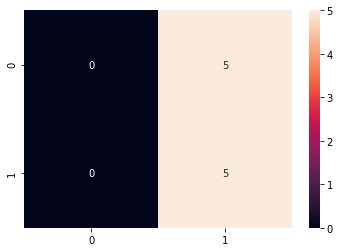

In [7]:
cm = metrics.confusion_matrix(test_data_generator.classes, y_pred)
sns.heatmap(cm, annot = True)

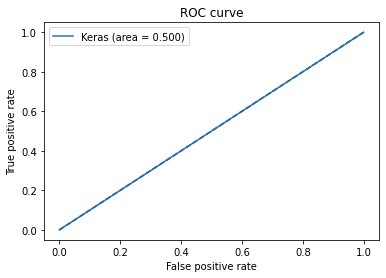

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_data_generator.classes, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

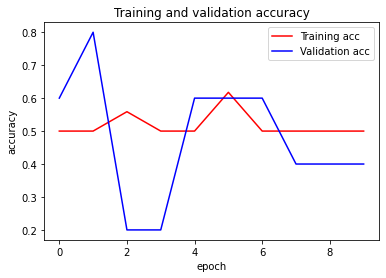

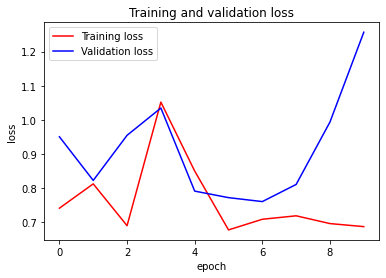

In [9]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history["val_accuracy"]
loss = history_resnet.history["loss"]
val_loss = history_resnet.history["val_loss"]
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()
